<a href="https://colab.research.google.com/github/mantavyam/magazine-automate/blob/main/MAG_DB_AUTOMATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MAG-DB AUTOMATION**
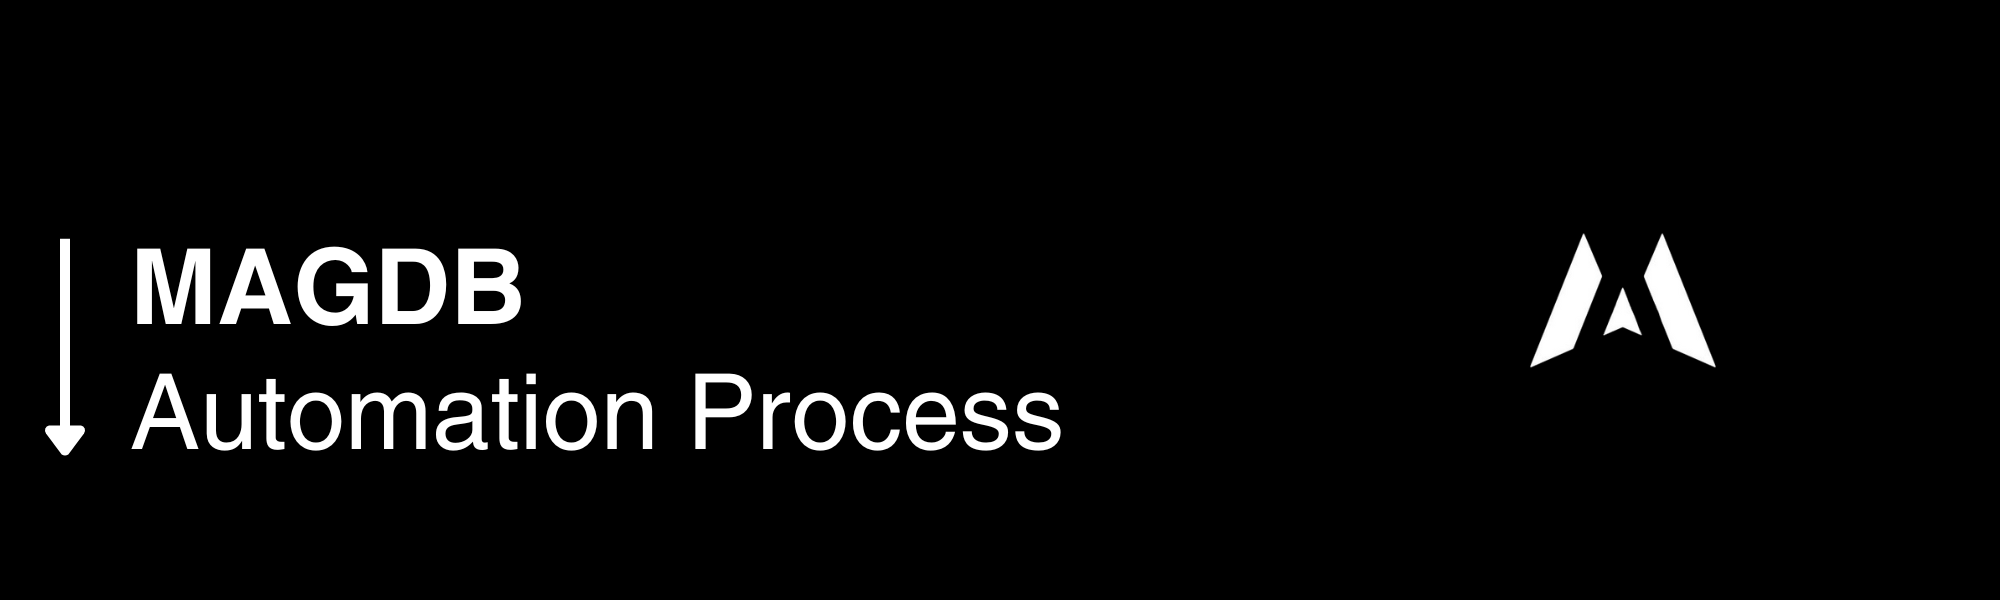
## License
Project Licensed under the MIT License

## Developer:
Mantavyam Studios, India

## IMPORTANT INFO:
* Enter the exact FILENAME.
* Do not alter the code.
* Only work with the CODERUN button and FILENAME box.

## ERROR RESOLUTION
> File Not Found Error
1. Enter the exact filename without any space.
2. Make Sure File Exists in Correct Location (Main Home Page).
3. (Wait few seconds) Sometimes Immediately Running the Code moments after the file was created will result in file being unrecognized by our Code, Reload the Drive Page and Open the File in New Tab then retry the code run.

## WARNING
> ⚠🏮 DO NOT CHANGE ANY CODE, ONLY USE THE CODE RUN BUTTON

# **PROCESS: 1 [Newsletter-DAILY]**

##CREATE RAW

Under Testing: Refined version of Creating RAW NEWSLETTER DOCUMENT.

> Needs Attention when:

- More than 1 "About Table" on same slide. ex: 01-02-25.pptx
- If News-Categories are not mentioned on slides, then you'll need to manually insert them as Heading level 1
- Adds Bullet Points to all sentences which are not news headline, May require manual removal of bullets if a line is not in bullet syntax.
- If a hindi word is mentioned in between an english sentence, whole line may be skipped. ex: 21-02-25.pptx
---
SOLUTION: Check the Newsletter Docs side by side with PPTX before designing to confirm if everything is intact.



In [ ]:
# Install required libraries
!pip install python-pptx
!pip install python-docx

# Import necessary modules
from google.colab import auth
from google.colab import drive
import os
import re
from pptx import Presentation
from docx import Document
from docx.oxml.ns import qn
from docx.oxml import OxmlElement

# Authenticate and mount Google Drive
auth.authenticate_user()
drive.mount('/content/drive')

# Function to detect Hindi text
def has_hindi(text):
    """Check if the text contains Hindi (Devanagari) characters."""
    return bool(re.search(r'[\u0900-\u097F]', text))

# Function to get top-left rectangles for 'News-Heading'
def get_top_left_rectangles(slide, slide_width, slide_height):
    """Get rectangles in the top-left quadrant of the slide."""
    top_left_rects = [
        shape for shape in slide.shapes
        if shape.has_text_frame and shape.shape_type == 1  # Rectangle shape
        and shape.top < slide_height / 3  # Top third
        and shape.left < slide_width / 3  # Left third
    ]
    return sorted(top_left_rects, key=lambda s: (s.top, s.left))

# Function to extract 'News-Heading'
def extract_news_heading(slide, slide_width, slide_height):
    """Extracts the news heading from top-left rectangles."""
    rects = get_top_left_rectangles(slide, slide_width, slide_height)
    return rects[0].text_frame.text.strip() if rects else None

# Function to process a single slide
def process_slide(slide, slide_width, slide_height):
    """
    Extract 'News-Category', 'News-Heading', 'News-Data', and tables from a slide.
    Returns: (category_text, heading_text, news_data, general_tables, associated_tables)
    """
    # Get all text shapes
    text_shapes = [shape for shape in slide.shapes if shape.has_text_frame]
    if not text_shapes:
        return None, None, "", [], []  # Skip slides with no text

    # Extract 'News-Heading' (top-left rectangle)
    heading_text = extract_news_heading(slide, slide_width, slide_height)

    # Identify 'News-Category' (top-right text shape with conditions)
    top_text_shapes = sorted(text_shapes, key=lambda s: s.top)
    category_shape = None
    category_text = None
    if top_text_shapes:
        rightmost_top = max(top_text_shapes, key=lambda s: s.left)
        text = rightmost_top.text.strip()
        if ('kapil kathpal' not in text.lower() and
            len(text.split()) < 3 and
            rightmost_top.text.strip() != heading_text):  # Ensure not the heading
            category_shape = rightmost_top
            category_text = text.upper()  # Convert to uppercase

    # Identify 'Author-Tag' shapes
    author_shapes = [shape for shape in text_shapes if 'kapil kathpal' in shape.text.lower()]

    # Identify 'About' shapes for 'General-Table'
    about_shapes = [shape for shape in text_shapes if shape.text.strip().lower().startswith('about')]

    # Collect 'News-Data' (exclude special shapes and Hindi text)
    news_data_shapes = [
        shape for shape in text_shapes
        if shape not in [category_shape] + author_shapes + about_shapes
        and shape.text.strip() != heading_text  # Exclude heading text
    ]
    news_data = '\n'.join([
        line.strip() for shape in news_data_shapes
        for line in shape.text.split('\n') if line.strip() and not has_hindi(line)
    ])

    # Collect 'General-Table' and 'Associated-Table'
    general_tables = []
    associated_tables = []
    prev_about = None
    for i, shape in enumerate(slide.shapes):
        if shape.has_text_frame and shape.text.strip().lower().startswith('about'):
            prev_about = shape.text.strip()
        elif shape.has_table:
            if prev_about and i > 0 and slide.shapes[i-1].text.strip().lower().startswith('about'):
                general_tables.append((prev_about, shape.table))  # Keep separate
                prev_about = None
            else:
                associated_tables.append(shape.table)
        else:
            prev_about = None

    return category_text, heading_text, news_data, general_tables, associated_tables

# Function to add bullet points to a paragraph
def add_bullet_paragraph(doc, text):
    """Add text as a bulleted list, one bullet per line."""
    lines = text.split('\n')
    for line in lines:
        if line.strip():  # Skip empty lines
            p = doc.add_paragraph(style='List Bullet')
            p.add_run(line.strip())

# Main function to convert PPTX to DOCX
def convert_pptx_to_docx(pptx_path):
    """Convert a PowerPoint newsletter to a formatted Word document."""
    # Load PowerPoint presentation
    prs = Presentation(pptx_path)
    pptx_filename = os.path.basename(pptx_path).replace('.pptx', '')

    # Get slide dimensions
    slide_width = prs.slide_width
    slide_height = prs.slide_height

    # Create Word document
    doc = Document()
    doc.add_paragraph(pptx_filename, style='Title')

    # Initialize tracking variables
    current_category = None
    current_headline = None
    headline_data = ""
    general_tables = []
    associated_tables = []

    # Process each slide
    for slide in prs.slides:
        category_text, heading_text, news_data, slide_general_tables, slide_associated_tables = process_slide(slide, slide_width, slide_height)

        # Handle new 'News-Category'
        if category_text and category_text != current_category:
            # Write previous headline if exists
            if current_headline:
                doc.add_heading(current_headline, level=3)
                add_bullet_paragraph(doc, headline_data.strip())  # Add as bullets
                for about_text, table in general_tables:
                    doc.add_paragraph(about_text)
                    doc_table = doc.add_table(rows=len(table.rows), cols=len(table.columns))
                    for row_idx, row in enumerate(table.rows):
                        for col_idx, cell in enumerate(row.cells):
                            doc_table.cell(row_idx, col_idx).text = cell.text
                for table in associated_tables:
                    doc_table = doc.add_table(rows=len(table.rows), cols=len(table.columns))
                    for row_idx, row in enumerate(table.rows):
                        for col_idx, cell in enumerate(row.cells):
                            doc_table.cell(row_idx, col_idx).text = cell.text

            # Set new category
            current_category = category_text
            doc.add_heading(current_category, level=1)
            doc.add_heading(pptx_filename, level=2)
            current_headline = None
            headline_data = ""
            general_tables = []
            associated_tables = []

        # Handle new 'News-Heading'
        if heading_text:
            # Write previous headline if exists
            if current_headline:
                doc.add_heading(current_headline, level=3)
                add_bullet_paragraph(doc, headline_data.strip())  # Add as bullets
                for about_text, table in general_tables:
                    doc.add_paragraph(about_text)
                    doc_table = doc.add_table(rows=len(table.rows), cols=len(table.columns))
                    for row_idx, row in enumerate(table.rows):
                        for col_idx, cell in enumerate(row.cells):
                            doc_table.cell(row_idx, col_idx).text = cell.text
                for table in associated_tables:
                    doc_table = doc.add_table(rows=len(table.rows), cols=len(table.columns))
                    for row_idx, row in enumerate(table.rows):
                        for col_idx, cell in enumerate(row.cells):
                            doc_table.cell(row_idx, col_idx).text = cell.text

            # Set new headline
            current_headline = heading_text
            headline_data = news_data
            general_tables = slide_general_tables
            associated_tables = slide_associated_tables
        else:
            # Continuation slide: append data and tables
            if current_headline and news_data:
                headline_data += '\n' + news_data
            general_tables.extend(slide_general_tables)
            associated_tables.extend(slide_associated_tables)

    # Write the last headline if exists
    if current_headline:
        doc.add_heading(current_headline, level=3)
        add_bullet_paragraph(doc, headline_data.strip())  # Add as bullets
        for about_text, table in general_tables:
            doc.add_paragraph(about_text)
            doc_table = doc.add_table(rows=len(table.rows), cols=len(table.columns))
            for row_idx, row in enumerate(table.rows):
                for col_idx, cell in enumerate(row.cells):
                    doc_table.cell(row_idx, col_idx).text = cell.text
        for table in associated_tables:
            doc_table = doc.add_table(rows=len(table.rows), cols=len(table.columns))
            for row_idx, row in enumerate(table.rows):
                for col_idx, cell in enumerate(row.cells):
                    doc_table.cell(row_idx, col_idx).text = cell.text

    # Save the document
    output_path = f'/content/drive/MyDrive/NEWSLETTER-{pptx_filename}-RAW.docx'
    doc.save(output_path)
    print(f"Document saved to: {output_path}")

# User input for PPTX filename
pptx_file_name = input("Enter the exact name of the PPTX file stored in Google Drive (e.g., '01-01-25.pptx'): ")
pptx_path = os.path.join("/content/drive/MyDrive/", pptx_file_name)
convert_pptx_to_docx(pptx_path)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 8.0 MB/s eta 0:00:00
Mounted at /content/drive
Enter the exact name of the PPTX file stored in Google Drive (e.g., '1-1-25.pptx'): 001-02-25.pptx
Document saved to: /content/drive/MyDrive/NEWSLETTER-001-02-25-RAW.docx




```
PATH = /content/drive/MyDrive/MAGDB/M2-FEB25/Daily-NEWSLETTER-FEB25-Raw/
```



## EXTRACT IMG DATA

Under Testing: Refined version of Extracting Images from PPTX:

> Enter 'Y' When:

- You are explicitly told to include Ad-Images (Big-Img)
- If any News includes extra image to support explanation of the topic which is sometimes required in Categories like: 'Geopolitics/Burning-Issue' or 'Banking', then add those images at the end of Newsletter with a caption text mentioning "Image associated with topic....'
---
SOLUTION: Check the PPTX before extracting Images to confirm if "Big Images" are required or not.



In [ ]:
# Install required libraries
!pip install python-pptx

# Import necessary modules
import os
import re
from pptx import Presentation
from pptx.enum.shapes import MSO_SHAPE_TYPE
from google.colab import auth, drive
import io
from PIL import Image

# Authenticate and mount Google Drive
auth.authenticate_user()
drive.mount('/content/drive')

# Function to check if a slide has any text (including in tables)
def has_text_on_slide(slide):
    """
    Determines if a slide contains any text elements, including text in tables.
    Returns:
        bool: True if text is present, False otherwise.
    """
    for shape in slide.shapes:
        if shape.has_text_frame and shape.text.strip():
            return True
        elif shape.has_table:
            for row in shape.table.rows:
                for cell in row.cells:
                    if cell.text.strip():
                        return True
    return False

# Function to get top-left rectangles for 'News-Heading'
def get_top_left_rectangles(slide, slide_width, slide_height):
    """
    Identifies rectangles in the top-left quadrant of the slide for 'News-Heading'.
    Args:
        slide: The slide object from python-pptx.
        slide_width (int): Width of the slide.
        slide_height (int): Height of the slide.
    Returns:
        list: Sorted list of shapes in the top-left quadrant.
    """
    top_left_rects = [
        shape for shape in slide.shapes
        if shape.has_text_frame and shape.shape_type == 1  # Rectangle shape
        and shape.top < slide_height / 3  # Top third
        and shape.left < slide_width / 3  # Left third
    ]
    return sorted(top_left_rects, key=lambda s: (s.top, s.left))

# Function to extract 'News-Heading'
def extract_news_heading(slide, slide_width, slide_height):
    """
    Extracts the 'News-Heading' from top-left rectangles.
    Args:
        slide: The slide object from python-pptx.
        slide_width (int): Width of the slide.
        slide_height (int): Height of the slide.
    Returns:
        str or None: The heading text if found, else None.
    """
    rects = get_top_left_rectangles(slide, slide_width, slide_height)
    return rects[0].text_frame.text.strip() if rects else None

# Function to process a slide for 'News-Category' and 'News-Heading'
def process_slide(slide, slide_width, slide_height):
    """
    Extracts 'News-Category' and 'News-Heading' from a slide.
    Args:
        slide: The slide object from python-pptx.
        slide_width (int): Width of the slide.
        slide_height (int): Height of the slide.
    Returns:
        tuple: (category_text, heading_text)
    """
    text_shapes = [shape for shape in slide.shapes if shape.has_text_frame]
    if not text_shapes:
        return None, None

    # Extract 'News-Heading' (top-left rectangle)
    heading_text = extract_news_heading(slide, slide_width, slide_height)

    # Identify 'News-Category' (top-right text shape with conditions)
    top_text_shapes = sorted(text_shapes, key=lambda s: s.top)
    category_shape = None
    category_text = None
    if top_text_shapes:
        rightmost_top = max(top_text_shapes, key=lambda s: s.left)
        text = rightmost_top.text.strip()
        if ('kapil kathpal' not in text.lower() and
            len(text.split()) < 3 and
            rightmost_top.text.strip() != heading_text):
            category_shape = rightmost_top
            category_text = text.upper()

    return category_text, heading_text

# Function to get image extension based on content type
def get_image_extension(content_type):
    """
    Maps MIME content type to image file extension.
    Args:
        content_type (str): MIME type of the image.
    Returns:
        str: Corresponding file extension.
    """
    if content_type == 'image/jpeg':
        return '.jpg'
    elif content_type == 'image/png':
        return '.png'
    elif content_type == 'image/gif':
        return '.gif'
    else:
        return '.img'  # Default

# Main function to extract images
def extract_images_from_pptx(pptx_path, folder_path, include_adverts):
    """
    Extracts images from the PPTX file and saves them to Google Drive.
    Args:
        pptx_path (str): Path to the PPTX file in Google Drive.
        folder_path (str): Path to the folder where images will be saved.
        include_adverts (bool): Whether to include advertisement images.
    """
    presentation = Presentation(pptx_path)
    slide_width = presentation.slide_width
    slide_height = presentation.slide_height

    general_slide_index = 1
    advert_image_index = 1
    current_category = None

    for slide_number, slide in enumerate(presentation.slides, start=1):
        if not has_text_on_slide(slide):
            # Advertisement slide
            if include_adverts:
                for shape in slide.shapes:
                    if shape.shape_type == MSO_SHAPE_TYPE.PICTURE:
                        image = shape.image
                        image_stream = io.BytesIO(image.blob)
                        img = Image.open(image_stream)
                        ext = get_image_extension(image.content_type)
                        pptx_base_name = os.path.splitext(os.path.basename(pptx_path))[0]
                        img_file_name = f"BIG-AD-TYPE-{pptx_base_name}-({advert_image_index}){ext}"
                        img_file_path = os.path.join(folder_path, img_file_name)
                        img.save(img_file_path)
                        print(f"Saved Big-Ad image: {img_file_name}")
                        advert_image_index += 1
        else:
            # General slide
            category_text, heading_text = process_slide(slide, slide_width, slide_height)
            if category_text:
                current_category = category_text
            if not heading_text:
                heading_text = "No_Heading"
            # Extract the first image
            for shape in slide.shapes:
                if shape.shape_type == MSO_SHAPE_TYPE.PICTURE:
                    image = shape.image
                    image_stream = io.BytesIO(image.blob)
                    img = Image.open(image_stream)
                    ext = get_image_extension(image.content_type)
                    # Sanitize heading and category for filename
                    safe_heading = re.sub(r'[^\w\s-]', '', heading_text).strip().replace(' ', '_')
                    safe_category = re.sub(r'[^\w\s-]', '', current_category or '').strip().replace(' ', '_')
                    pptx_base_name = os.path.splitext(os.path.basename(pptx_path))[0]
                    img_file_name = f"{general_slide_index}-{safe_heading[:40]}-({safe_category})-{pptx_base_name}{ext}"
                    img_file_path = os.path.join(folder_path, img_file_name)
                    img.save(img_file_path)
                    print(f"Saved News image: {img_file_name}")
                    general_slide_index += 1
                    break  # Only extract the first image

# User input for PPTX file name
pptx_file_name = input("Enter the exact name of the PPTX file stored in Google Drive (e.g., '01-01-25.pptx'): ")
pptx_path = os.path.join("/content/drive/My Drive/", pptx_file_name)

# Check if the file exists
if not os.path.exists(pptx_path):
    raise FileNotFoundError(f"The file {pptx_file_name} does not exist in Google Drive.")

# Create image folder
folder_name = os.path.splitext(pptx_file_name)[0] + "-IMAGES"
folder_path = os.path.join("/content/drive/My Drive/", folder_name)
os.makedirs(folder_path, exist_ok=True)

# Ask user if they want to include advertisement images
include_adverts = input("Do you want to include Big Ad. Type Images? y=yes & n=no, choose one option (y/n): ").strip().lower() == 'y'

# Extract images
extract_images_from_pptx(pptx_path, folder_path, include_adverts)

print("Image extraction completed.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Enter the exact name of the PPTX file stored in Google Drive (e.g., '01-01-25.pptx'): 21-02-25.pptx
Do you want to include Big Ad. Type Images? y=yes & n=no, choose one option (y/n): n
Saved News image: 1-RBI_Ombudsman_Called_As_रजरवबक_ओमबडसमन_य-(RBI)-21-02-25.png
Saved News image: 2-SEBI_Introduced_New_Rules_for_Disclosure-(RBI)-21-02-25.png
Saved News image: 3-National_Geospatial_Knowledge-Based_Land-(NATIONAL)-21-02-25.png
Saved News image: 4-TrailGuard_AI-(NATIONAL)-21-02-25.png
Saved News image: 5-Indias_First_Open-Air_Art_Wall_Museum_In-(NATIONAL)-21-02-25.png
Saved News image: 6-Volvo_Trucks_Launches_Indias_First_Road_-(NATIONAL)-21-02-25.png
Saved News image: 7-Google_unveils_Ananta_its_largest_campus-(NATIONAL)-21-02-25.png
Saved News image: 8-RSS_Inaugurates_New_Headquarters_Keshav_-(NATIONAL)-21-02-25.png
Saved News image: 9-Keralas_Karunya Arogya 



---



# **PROCESS: 2 [Compilation-WEEKLY]**

In [ ]:
# Install the necessary libraries
!pip install --upgrade google-auth google-auth-httplib2 google-auth-oauthlib google-api-python-client

from google.colab import auth, drive
from googleapiclient.discovery import build
from datetime import datetime

# Authenticate and create the service
auth.authenticate_user()
drive.mount('/content/drive')

# Set up the Drive and Docs API clients
drive_service = build('drive', 'v3')
docs_service = build('docs', 'v1')

# Function to get input from the user
def get_newsletter_files():
    num_files = int(input("Enter the number of newsletters to merge: "))
    filenames = []
    for _ in range(num_files):
        filename = input("Enter the exact name of the newsletter file: ")
        filenames.append(filename)
    return filenames

# Get the filenames from the user
newsletter_files = get_newsletter_files()

# Create a new document for the weekly compilation
current_month_year = datetime.now().strftime("%B-%Y")
weekly_compilation_title = f"WK-COMPILE-{current_month_year}"

# Create the new Google Doc
document = docs_service.documents().create(body={'title': weekly_compilation_title}).execute()
document_id = document.get('documentId')

# Function to insert text into the Google Doc
def insert_text(document_id, text, location=None):
    requests = [
        {
            'insertText': {
                'location': {
                    'index': location if location else 1,
                },
                'text': text
            }
        }
    ]
    docs_service.documents().batchUpdate(documentId=document_id, body={'requests': requests}).execute()

# Function to insert a table into the Google Doc
def insert_table(document_id, rows, cols, location=None):
    requests = [
        {
            'insertTable': {
                'rows': rows,
                'columns': cols,
                'location': {
                    'index': location if location else 1,
                }
            }
        }
    ]
    response = docs_service.documents().batchUpdate(documentId=document_id, body={'requests': requests}).execute()
    table_id = response['replies'][0]['insertTable']['tableId']
    return table_id

# Function to update table cell content
def update_table_cell(document_id, table_id, row, col, text):
    # Calculate the position in the document where text should be inserted
    requests = [
        {
            'insertText': {
                'location': {
                    'index': calculate_cell_index(document_id, table_id, row, col),
                },
                'text': text
            }
        }
    ]
    docs_service.documents().batchUpdate(documentId=document_id, body={'requests': requests}).execute()

# Function to calculate the index for the cell text
def calculate_cell_index(document_id, table_id, row, col):
    # Placeholder function, this should be implemented based on the table's location
    # and cell index calculation logic.
    return 1  # This is just a placeholder; actual implementation needed.

# Insert the title as heading level 0
insert_text(document_id, f"{weekly_compilation_title}\n\n")

# Insert MCQ Qs section as heading level 1
insert_text(document_id, "MCQ Qs\n", location=1)

# Variable to keep track of the current insertion index
current_index = 1

for newsletter_file in newsletter_files:
    # Search for the file in Google Drive
    response = drive_service.files().list(q=f"name='{newsletter_file}' and mimeType='application/vnd.google-apps.document'", fields="files(id, name)").execute()
    files = response.get('files', [])
    if not files:
        print(f"File '{newsletter_file}' not found.")
        continue

    file_id = files[0]['id']

    # Get the content of the newsletter file
    doc = docs_service.documents().get(documentId=file_id).execute()
    content = doc.get('body').get('content')

    # Insert the newsletter file name as heading level 2
    insert_text(document_id, f"{newsletter_file}\n", location=current_index)
    current_index += len(newsletter_file) + 1

    # Find and insert the MCQ table
    table_found = False
    for element in content:
        if 'table' in element:
            table = element['table']
            if len(table['tableRows']) == 6 and len(table['tableRows'][0]['tableCells']) == 2:
                table_found = True

                # Insert the table
                table_id = insert_table(document_id, 6, 2, location=current_index)
                current_index += 2

                # Update the table cells with the content
                for row_index, row in enumerate(table['tableRows']):
                    for col_index, cell in enumerate(row['tableCells']):
                        cell_content = cell['content']
                        cell_text = ""
                        for item in cell_content:
                            if 'paragraph' in item:
                                elements = item['paragraph']['elements']
                                for elem in elements:
                                    if 'textRun' in elem:
                                        cell_text += elem['textRun']['content']
                        update_table_cell(document_id, table_id, row_index, col_index, cell_text)
                break

    if not table_found:
        print(f"MCQ table not found in '{newsletter_file}'.")

print(f"Weekly compilation file created with ID: {document_id}")


# **PROCESS: 3 [Magazine-Monthly]**

## MCQ FORMATTING

In [ ]:
!pip install python-docx
from google.colab import drive
import os
from docx import Document

# Authenticate and mount Google Drive
drive.mount('/content/drive')

# Function to remove Hindi text from a paragraph
def remove_hindi_text(paragraph):
    hindi_chars = set("अ आ इ ई उ ऊ ऋ ए ऐ ओ औ क ख ग घ च छ ज झ ट ठ ड ढ ण त थ द ध न प फ ब भ म य र ल व श ष स ह ा ि ी ु ू ृ ॅ े ै ो ौ ्".split())
    for run in paragraph.runs:
        text = run.text.split('/')
        if len(text) > 1 and any(char in hindi_chars for char in text[1]):
            run.text = text[0] + '/'

# Function to remove Hindi text from the document
def remove_hindi_from_docx(docx_file):
    doc = Document(docx_file)
    for paragraph in doc.paragraphs:
        remove_hindi_text(paragraph)
    doc.save(docx_file)

# Input file name
file_name = input("Enter the file name: ")

# Path to the file
file_path = os.path.join("/content/drive/My Drive/", file_name)

# Remove Hindi text from the document
remove_hindi_from_docx(file_path)

print("Hindi text removed and document saved successfully.")

Mounted at /content/drive
Enter the file name: MCQ.docx
Hindi text removed and document saved successfully.


## EXTRACT ANSKEY + ADD Qs NO

In [ ]:
from google.colab import drive
import docx
import os

def mount_drive():
    """Mount Google Drive and return the mount point."""
    drive.mount('/content/drive')
    return '/content/drive/MyDrive/'

def number_questions(doc_path):
    """
    Add sequential numbering to questions starting with 'Q.'
    Returns the path of the new numbered document.
    """
    # Load the document
    doc = docx.Document(doc_path)
    question_count = 0

    # Process each paragraph
    for paragraph in doc.paragraphs:
        if paragraph.text.strip().startswith('Q.'):
            question_count += 1
            # Get the text after 'Q.' and preserve any existing formatting
            original_text = paragraph.text[2:].strip()  # Remove 'Q.' and any immediate spaces

            # Clear the paragraph
            paragraph.clear()

            # Add the new numbered question format
            run = paragraph.add_run(f'Q{question_count}. {original_text}')

            # Preserve original formatting if any
            for old_run in paragraph.runs[1:]:  # Skip the first run which we just added
                new_run = paragraph.add_run(old_run.text)
                # Copy formatting
                new_run.bold = old_run.bold
                new_run.italic = old_run.italic
                new_run.underline = old_run.underline
                if old_run.font.color.rgb:
                    new_run.font.color.rgb = old_run.font.color.rgb

    # Save as new document with '_numbered' suffix
    base_name = os.path.splitext(doc_path)[0]
    new_path = f"{base_name}_numbered.docx"
    doc.save(new_path)
    print(f"Added numbering to {question_count} questions.")
    return new_path

def process_document(doc_path):
    """
    Process the document to extract questions and answers based on text color.
    Returns a dictionary of question numbers and their answers.
    """
    # Load the document
    doc = docx.Document(doc_path)
    answers_dict = {}
    current_question = 0

    # Process each paragraph
    for paragraph in doc.paragraphs:
        text = paragraph.text.strip()
        if text.startswith('Q'):  # Changed to handle both 'Q.' and 'Q1.' format
            current_question += 1

        # Check for colored text in the paragraph
        for run in paragraph.runs:
            if run.font.color.rgb and text.strip():  # If text has color
                answers_dict[current_question] = text.strip()
                break

    return answers_dict

def create_answer_table(doc_path, answers):
    """
    Create a table at the end of the document with question numbers and answers.
    """
    # Load the document
    doc = docx.Document(doc_path)

    # Add page break
    doc.add_page_break()

    # Add heading for answer key
    doc.add_heading('Answer Key', level=1)

    # Create table
    table = doc.add_table(rows=len(answers) + 1, cols=2)

    # Add headers with formatting
    header_cells = table.rows[0].cells
    header_cells[0].text = 'Question Number'
    header_cells[1].text = 'Answer'

    # Make headers bold
    for cell in header_cells:
        for paragraph in cell.paragraphs:
            for run in paragraph.runs:
                run.bold = True

    # Add borders to all cells (basic border)
    for row in table.rows:
        for cell in row.cells:
            # Add minimal padding to cells
            for paragraph in cell.paragraphs:
                paragraph.paragraph_format.space_before = docx.shared.Pt(6)
                paragraph.paragraph_format.space_after = docx.shared.Pt(6)

    # Add data
    for i, (question, answer) in enumerate(answers.items(), 1):
        row_cells = table.rows[i].cells
        row_cells[0].text = str(question)
        row_cells[1].text = str(answer)

    # Save the document with a new name
    base_name = os.path.splitext(doc_path)[0]
    new_path = f"{base_name}_with_answers.docx"
    doc.save(new_path)
    return new_path

def main():
    """Main function to process the document."""
    try:
        # Mount Google Drive
        drive_path = mount_drive()
        print("Google Drive mounted successfully.")

        # Get filename from user
        filename = input("Enter the name of your document file (with .docx extension): ")
        file_path = os.path.join(drive_path, filename)

        # Check if file exists
        if not os.path.exists(file_path):
            print(f"Error: File '{filename}' not found in Google Drive root folder.")
            return

        # Ask user what they want to do
        print("\nWhat would you like to do?")
        print("1. Add question numbering only")
        print("2. Create answer table only")
        print("3. Both numbering and answer table")
        choice = input("Enter your choice (1, 2, or 3): ")

        if choice in ['1', '3']:
            print("\nAdding question numbering...")
            numbered_path = number_questions(file_path)
            print(f"Numbered document saved as: {os.path.basename(numbered_path)}")

            if choice == '3':
                file_path = numbered_path  # Use the numbered document for answer table

        if choice in ['2', '3']:
            print("\nProcessing document for answers...")
            answers = process_document(file_path)

            if answers:
                new_file_path = create_answer_table(file_path, answers)
                print(f"Answer table has been created successfully!")
                print(f"Processed {len(answers)} questions.")
                print(f"Final file saved as: {os.path.basename(new_file_path)}")
            else:
                print("No questions with colored answers found in the document.")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Enter the name of your document file (with .docx extension): MCQ.docx

What would you like to do?
1. Add question numbering only
2. Create answer table only
3. Both numbering and answer table
Enter your choice (1, 2, or 3): 3

Adding question numbering...
Added numbering to 100 questions.
Numbered document saved as: MCQ_numbered.docx

Processing document for answers...
Answer table has been created successfully!
Processed 100 questions.
Final file saved as: MCQ_numbered_with_answers.docx


# ARCHIVED (OLD CODE)

> Don't use these old Codes, Use the latest version!

In [ ]:
"""
OLD CODE FOR CREATE RAW
REQUIRED MANUAL FORMATTING OF NEWS-CATEGORY AND TABLE ADJUSTMENTS
BEFORE CREATING A DESIGN.
- MOST THINGS WERE MANUAL
- DID GOOD JOB AT DATA SCRAPING FROM PPTX
- TOOK 10+ MINUTES IN THE WHOLE PROCESS OF NEWSLETTER CREATION

SOLUTION: UPDATED THE COMPLETE CODEBASE AND USED NEW APPROACH
"""
# Install necessary libraries at the top
!pip install python-pptx
!pip install python-docx

from google.colab import auth, drive
from pptx import Presentation
from docx import Document
from docx.shared import Pt
from docx.enum.table import WD_TABLE_ALIGNMENT
from docx.enum.text import WD_ALIGN_PARAGRAPH
import os
import re
from datetime import datetime

# Authenticate and mount Google Drive
auth.authenticate_user()
drive.mount('/content/drive')

# Function to check if text is in Hindi
def is_hindi(text):
    hindi_chars = [chr(i) for i in range(2304, 2432)]  # Unicode range for Hindi characters
    return any(char in hindi_chars for char in text)

# Function to extract text and table data from a PPTX file
def extract_text_and_tables_from_pptx(pptx_path):
    presentation = Presentation(pptx_path)
    slides_data = []

    for slide in presentation.slides:
        slide_data = {"text": [], "tables": []}
        first_text = True

        for shape in slide.shapes:
            if shape.has_text_frame:
                for paragraph in shape.text_frame.paragraphs:
                    text = paragraph.text.strip()
                    if text:
                        if first_text and not text.startswith("About") and 15 < len(text) < 120:
                            slide_data["text"].append(("headline", text))
                            first_text = False
                        else:
                            slide_data["text"].append(("paragraph", text))
            if shape.has_table:
                table_data = []
                table = shape.table
                for row in table.rows:
                    row_data = [cell.text for cell in row.cells]
                    table_data.append(row_data)
                slide_data["tables"].append(table_data)

        slides_data.append(slide_data)

    return slides_data

# Function to create a DOCX file with extracted data
def create_docx_with_data(docx_path, slides_data):
    document = Document()

    # Add the current date as a title (formatted as DD-MM-YY)
    current_date = datetime.now().strftime("%d-%m-%y")
    title = document.add_heading(level=0)
    run = title.add_run(current_date)
    run.bold = True
    run.font.size = Pt(24)

    for slide_index, slide in enumerate(slides_data):
        if slide_index > 0:
            slide_divider = document.add_paragraph("NEWSLIDE")  # Add slide divider
            slide_divider.alignment = WD_ALIGN_PARAGRAPH.CENTER

        # Add text data
        for text_type, text in slide["text"]:
            if text_type == "headline":
                document.add_heading(text, level=2)
            else:
                document.add_paragraph(text)

        # Add table data
        for table in slide["tables"]:
            doc_table = document.add_table(rows=len(table), cols=len(table[0]))
            doc_table.alignment = WD_TABLE_ALIGNMENT.CENTER

            for i, row in enumerate(table):
                for j, cell_text in enumerate(row):
                    cell = doc_table.cell(i, j)
                    cell.text = cell_text

            for row in doc_table.rows:
                for cell in row.cells:
                    for paragraph in cell.paragraphs:
                        for run in paragraph.runs:
                            run.font.size = Pt(10)

    document.save(docx_path)

# Function to format the DOCX file
def format_docx(docx_path):
    document = Document(docx_path)
    for paragraph in document.paragraphs:
        if is_hindi(paragraph.text) or 'kapil kathpal' in paragraph.text.lower():
            p = paragraph._element
            p.getparent().remove(p)
            p._p = p._element = None

    for table in document.tables:
        for row in table.rows:
            for cell in row.cells:
                cell_paragraphs = list(cell.paragraphs)
                for paragraph in cell_paragraphs:
                    if is_hindi(paragraph.text) or 'kapil kathpal' in paragraph.text.lower():
                        p = paragraph._element
                        p.getparent().remove(p)
                        p._p = p._element = None

    document.save(docx_path)

# Function to identify categories and make them heading level 1
def identify_and_make_headings(docx_path):
    document = Document(docx_path)
    headings_style = document.styles['Heading 1']
    paragraphs = list(document.paragraphs)

    for i, paragraph in enumerate(paragraphs):
        text = paragraph.text.strip()
        if len(text) < 15 and not text.startswith("About") and "NEWSLIDE" not in text:
            paragraph.style = headings_style

    document.save(docx_path)

# Main function
def main():
    # Get the PPTX file name from user input
    pptx_file_name = input("Enter the exact name of the PPTX file stored in Google Drive (e.g., '1-1-24.pptx'): ")
    pptx_file_path = os.path.join("/content/drive/My Drive/", pptx_file_name)

    # Extract text and table data from the PPTX file
    slides_data = extract_text_and_tables_from_pptx(pptx_file_path)

    # Create a new DOCX file and save it to Google Drive
    docx_file_name = f"NEWSLETTER-{pptx_file_name.rsplit('.', 1)[0]}-RAW.docx"
    docx_file_path = os.path.join("/content/drive/My Drive/", docx_file_name)
    create_docx_with_data(docx_file_path, slides_data)

    # Format the newly created DOCX file
    format_docx(docx_file_path)

    # Identify and make categories heading level 1
    identify_and_make_headings(docx_file_path)

    print(f"Data extracted from '{pptx_file_name}' and saved into '{docx_file_name}' in Google Drive.")

# Execute main function
main()

In [ ]:
"""
OLD CODE FOR EXTRACTING IMAGES
REQUIRED MANUAL FORMATTING OF NEWS-CATEGORY AND TABLE ADJUSTMENTS
BEFORE CREATING A DESIGN.
- MOST THINGS WERE MANUAL
- DID GOOD JOB AT DATA SCRAPING FROM PPTX
- TOOK 10+ MINUTES IN THE WHOLE PROCESS OF NEWSLETTER CREATION

SOLUTION: UPDATED THE COMPLETE CODEBASE AND USED NEW APPROACH
"""
!pip install python-pptx
import os
from datetime import datetime
from pptx import Presentation
from pptx.enum.shapes import MSO_SHAPE_TYPE
from google.colab import drive, auth
from googleapiclient.discovery import build
import io
from PIL import Image

# Authenticate user
auth.authenticate_user()

# Mount Google Drive
drive.mount('/content/drive')

# Function to download the PPTX file from Google Drive
def download_pptx_file(file_name):
    file_path = f"/content/drive/My Drive/{file_name}"
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_name} does not exist in Google Drive.")
    return file_path

# Function to create a new folder in the same directory as the PPTX file
def create_image_folder(pptx_file_name):
    folder_name = os.path.splitext(pptx_file_name)[0] + "-IMAGES"
    folder_path = f"/content/drive/My Drive/{folder_name}"
    os.makedirs(folder_path, exist_ok=True)
    return folder_path

# Function to extract images from slides and save them
def extract_and_save_images(pptx_path, folder_path):
    presentation = Presentation(pptx_path)
    image_index = 1

    for slide_number, slide in enumerate(presentation.slides, start=1):
        slide_heading = "No_Heading"  # Default if no heading is found
        for shape in slide.shapes:
            if shape.has_text_frame and shape.text_frame.text:
                # Assuming the first shape with text is the heading
                slide_heading = shape.text_frame.text.split("\n")[0]
                break

        for shape in slide.shapes:
            if shape.shape_type == MSO_SHAPE_TYPE.PICTURE:
                image = shape.image
                image_stream = io.BytesIO(image.blob)
                img = Image.open(image_stream)

                img_file_name = f"{image_index}-{slide_heading[:30].replace(' ', '_')}.png"
                img_file_path = os.path.join(folder_path, img_file_name)
                img.save(img_file_path)

                print(f"Found img {image_index} saved to {folder_path}")
                image_index += 1

    print("All images saved successfully.")

# Main function
def main():
    pptx_file_name = input("Enter the name of the PPTX file (including extension) saved in Google Drive: ")
    pptx_path = download_pptx_file(pptx_file_name)

    folder_path = create_image_folder(pptx_file_name)
    extract_and_save_images(pptx_path, folder_path)

# Execute main function
main()